
| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| tomato   |토마토 가격/거래량 + 부산 날씨   +  소비자 물가지수 + 유가     |20190101 ~ 20200928|
| grape   | 캠벨얼리 가격/거래량 + 남원 날씨   +  소비자 물가지수 + 유가    |20190101 ~ 20200928|
| shinemuscat   |샤인마스캇  가격/거래량 + 구미 날씨   +  소비자 물가지수 + 유가          |20190101 ~ 20200928|
| train   |   tomato +  grape +  shinemuscat   | 20190101 ~ 20200928|
| test   |   tomato +  grape +  shinemuscat   | 20200929 ~ 20200928|
| df      | train + test       | 20190101 ~ 20201105|

## Overview

## 주제:  농산물 품목별로 가격 변동 예측 모델 구현

### 과제 선정 배경
코로나 사태가 지속되면서 온라인 시장이 급증하였다. 이에, 가격 변동 예측을 통해 필요한 상품을 필요한 주기에 적정가에 구매하여 구매 비용 및 폐기율 낮춰 생산량 조절


### 과제 주요 내용
- 농산물 가격은 추측이 어려운 경향이 있음. 기격에 영향을 미치는 요인으로 거래량, 기상, 가격,사회적인 이슈, 물가 상승률, 거래량, 유가, 생산량, 해외 수입량, 재배 면적 등 다양하지만, 그중 기상, 유가, 가격, 거래량 데이터를 이용. 해당 데이터들을 수집하여 전처리, 이상치 탐지, 정규화 등의 과정을 거친 뒤, 회귀 기법의 머신러닝 모델 및 딥러닝(LSTM)을 이용하여 모델을 학습하고 예측한다.
- 주기는 1주로 예측
- 이번 프로젝트에서는 토마토, 포도(캠벨얼리, 샤인마스캇) 총 3개의 작물에 대하여 가격 예측을 진행한다.
- 수요예측 -> 계획 생산 -> 좋은 품질을 연간 균일, 합리적인 가격

### 과제 목표
- 마켓컬리 '폐기율 0.1%' 도전, 고객의 성향이나 맥락, 상품 특성을 고려해 적절한 시기에 상품을 추천함으로써 고객이 원하는 상품을 빠르고 쉽게 찾아서 주문할 수 있도록 지원하기위해 가격 예측이 필요함
- 입력받은 일자의 1주 뒤의 가격을 예측하는 것을 목표로 한다. 예를 들어, 2021년 12월 31일의 데이터를 입력으로 한다면, 1월 7일, 1월 14일, 1월 28일의 가격을 수치형으로 예측한다. 모델의 성능 평가 지표는 농산물마다 가격 범위 차이가 큰 점을 반영하여 **``RMSE(Root-mean-square deviation)``** 를 사용하며, 해당 값이 0.2가 넘지 않게 하는 것을 목표로 한다.

### 데이터 수집
**train(학습용 데이터셋)**: ``20160101`` ~ ``20200928`` <br>
**test(테스트 테이터셋)**: ``20200929 + 1week``~ ``20201105 +4week``


[V] 데이터 수집 기한 정하기 <br>
[ ] NMSE(평가지표) 예측 주기 정하기

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
# import tensorflow as tf
# import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/var/folders/lm/z4n_2b8s6rj3_vv57sg789kc0000gn/T/ipykernel_61426/238796418.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 데이터셋(dataset)

**train** 20160101 ~ 20200928 <br> 
**test** 20200929 ~ 20201105

EDA와 기본 모델을 만들때 사용 <br>
train + test 합친 프레임(토마토, 포도) = df

In [3]:
raw_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

In [4]:
# test 데이터 합치기
arr = os.listdir('/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/data/public_data/test_files')
print(arr)
print()

filename_list = arr
filename_list_2020 = []    
for filename in filename_list :
    if '2020' in filename :
        filename_list_2020.append(filename)
        
path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/data/public_data/test_files/'
df_list = []
for filename in tqdm(filename_list_2020) :
    df = pd.read_csv(path + filename)
    df_list.append(df)
test = pd.concat(df_list, sort=False).reset_index(drop=True)

['test_2020-10-12.csv', 'test_2020-10-06.csv', 'test_2020-10-07.csv', 'test_2020-10-13.csv', 'test_2020-09-30.csv', 'test_2020-10-05.csv', 'test_2020-10-11.csv', 'test_2020-10-10.csv', 'test_2020-10-04.csv', 'test_2020-10-14.csv', 'test_2020-10-28.csv', 'test_2020-10-29.csv', 'test_2020-10-15.csv', 'test_2020-10-01.csv', 'test_2020-10-17.csv', 'test_2020-10-03.csv', 'test_2020-10-02.csv', 'test_2020-10-16.csv', 'test_2020-10-27.csv', 'test_2020-10-26.csv', 'test_2020-10-18.csv', 'test_2020-10-24.csv', 'test_2020-10-30.csv', 'test_2020-10-31.csv', 'test_2020-10-25.csv', 'test_2020-10-19.csv', 'test_2020-10-21.csv', 'test_2020-10-09.csv', 'test_2020-10-08.csv', 'test_2020-10-20.csv', 'test_2020-09-29.csv', 'test_2020-10-22.csv', 'test_2020-10-23.csv', '.ipynb_checkpoints', 'test_2020-11-04.csv', 'test_2020-11-05.csv', 'test_2020-11-02.csv', 'test_2020-11-03.csv', 'test_2020-11-01.csv']



100%|████████████████████████████████████████████████████| 38/38 [00:00<00:00, 562.58it/s]


In [19]:
tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'grape.csv')
shinemuscat = pd.read_csv(processed_path+'shinemuscat.csv')

train = pd.read_csv(raw_path+'train.csv')
test = pd.read_csv(raw_path+'test.csv')

print(train.shape)
print(test.shape)

(1733, 44)
(37, 44)


In [18]:
# tomato.date = pd.to_datetime(tomato.date)
# tomato = pd.concat([tomato, pd.get_dummies(tomato['요일'])], axis = 1)
# tomato['년'] = tomato['date'].dt.year 
# tomato['월'] = tomato['date'].dt.month 

# grape.date = pd.to_datetime(grape.date)
# grape = pd.concat([grape, pd.get_dummies(grape['요일'])], axis = 1)
# grape['년'] = grape['date'].dt.year 
# grape['월'] = grape['date'].dt.month 

# shinemuscat.date = pd.to_datetime(shinemuscat.date)
# shinemuscat = pd.concat([shinemuscat, pd.get_dummies(shinemuscat['요일'])], axis = 1)
# shinemuscat['년'] = shinemuscat['date'].dt.year 
# shinemuscat['월'] = shinemuscat['date'].dt.month 

In [20]:
tomato.drop(columns=[ '고급휘발유', '보통휘발유', '실내등유' ], inplace=True )
grape.drop(columns=[ '고급휘발유',  '보통휘발유', '실내등유' ], inplace=True )
shinemuscat.drop(columns=[ '고급휘발유', '보통휘발유','실내등유' ], inplace=True )

In [42]:
tomato.drop(columns=[  '최고기온', '최저기온'], inplace=True )
grape.drop(columns=[  '최고기온', '최저기온' ], inplace=True )
shinemuscat.drop(columns=[  '최고기온', '최저기온'], inplace=True )

In [21]:
print(tomato.shape)
print(grape.shape)
print(shinemuscat.shape)

(1733, 12)
(1733, 12)
(1733, 12)


## train 토마토, 포도(캠벨얼리, 샤인마스캇)만 저장

In [8]:
train = train[['date', '요일','토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]
test = test[['date', '요일','토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]

In [9]:
train.shape

(1733, 8)

In [10]:
df = pd.concat([train, test], axis= 0)
df.shape

(1770, 8)

In [11]:
df.date = pd.to_datetime(df.date)
df = pd.concat([df, pd.get_dummies(df['요일'])], axis = 1)
feature = train.columns[2:]

In [12]:
display(tomato.head(2))
display(tomato.tail(2))
print(tomato.shape)

,date,요일,토마토_거래량(kg),토마토_가격(원/kg),소비자물가지수,고급휘발유,보통휘발유,자동차용경유,실내등유,평균기온,...,일교차,금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
0,2016-01-01,금요일,0.0,0.0,95.232,1780.99,1407.15,1188.71,835.38,5.3,...,9.8,1,0,0,0,0,0,0,2016,1
1,2016-01-02,토요일,30950.0,1621.0,95.232,1781.69,1405.98,1187.91,834.11,8.1,...,7.6,0,0,0,0,0,1,0,2016,1


,date,요일,토마토_거래량(kg),토마토_가격(원/kg),소비자물가지수,고급휘발유,보통휘발유,자동차용경유,실내등유,평균기온,...,일교차,금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
1731,2020-09-27,일요일,910.0,3781.0,100.74,1624.01,1343.59,1145.23,815.78,20.0,...,8.7,0,0,0,0,1,0,0,2020,9
1732,2020-09-28,월요일,285116.5,5024.0,100.74,1623.24,1343.10,1144.85,815.68,19.4,...,8.1,0,0,0,1,0,0,0,2020,9


(1733, 24)


In [13]:
shinemuscat.shape

(1733, 24)

In [14]:
display(grape.head(2))
display(grape.tail(2))
print(grape.shape)

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),소비자물가지수,고급휘발유,보통휘발유,자동차용경유,실내등유,평균기온,...,일교차,금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
0,2016-01-01,금요일,0.0,0.0,95.232,1780.99,1407.15,1188.71,835.38,0.0,...,11.8,1,0,0,0,0,0,0,2016,1
1,2016-01-02,토요일,880.0,2014.0,95.232,1781.69,1405.98,1187.91,834.11,3.5,...,14.2,0,0,0,0,0,1,0,2016,1


,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),소비자물가지수,고급휘발유,보통휘발유,자동차용경유,실내등유,평균기온,...,일교차,금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
1731,2020-09-27,일요일,21717.0,3567.0,100.74,1624.01,1343.59,1145.23,815.78,19.9,...,10.0,0,0,0,0,1,0,0,2020,9
1732,2020-09-28,월요일,601841.0,3761.0,100.74,1623.24,1343.10,1144.85,815.68,18.2,...,13.0,0,0,0,1,0,0,0,2020,9


(1733, 24)


In [15]:
print(tomato.info())
print()
print(grape.info())
print()
print(shinemuscat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1733 non-null   datetime64[ns]
 1   요일            1733 non-null   object        
 2   토마토_거래량(kg)   1733 non-null   float64       
 3   토마토_가격(원/kg)  1733 non-null   float64       
 4   소비자물가지수       1733 non-null   float64       
 5   고급휘발유         1733 non-null   float64       
 6   보통휘발유         1733 non-null   float64       
 7   자동차용경유        1733 non-null   float64       
 8   실내등유          1733 non-null   float64       
 9   평균기온          1733 non-null   float64       
 10  최고기온          1733 non-null   float64       
 11  최저기온          1733 non-null   float64       
 12  평균운량          1733 non-null   float64       
 13  일강수량          1733 non-null   float64       
 14  일교차           1733 non-null   float64       
 15  금요일           1733 non-null   uint8   

# EDA
## train data 농산물 품목 별 가격
계절 패턴이 뚜렷하고 품목별로 확연히 다른 분포를 보임 -> 품목별 모델 생성, 시계열 반영 모델 생성

<AxesSubplot:title={'center':'토마토_가격(원/kg)'}, xlabel='기간'>

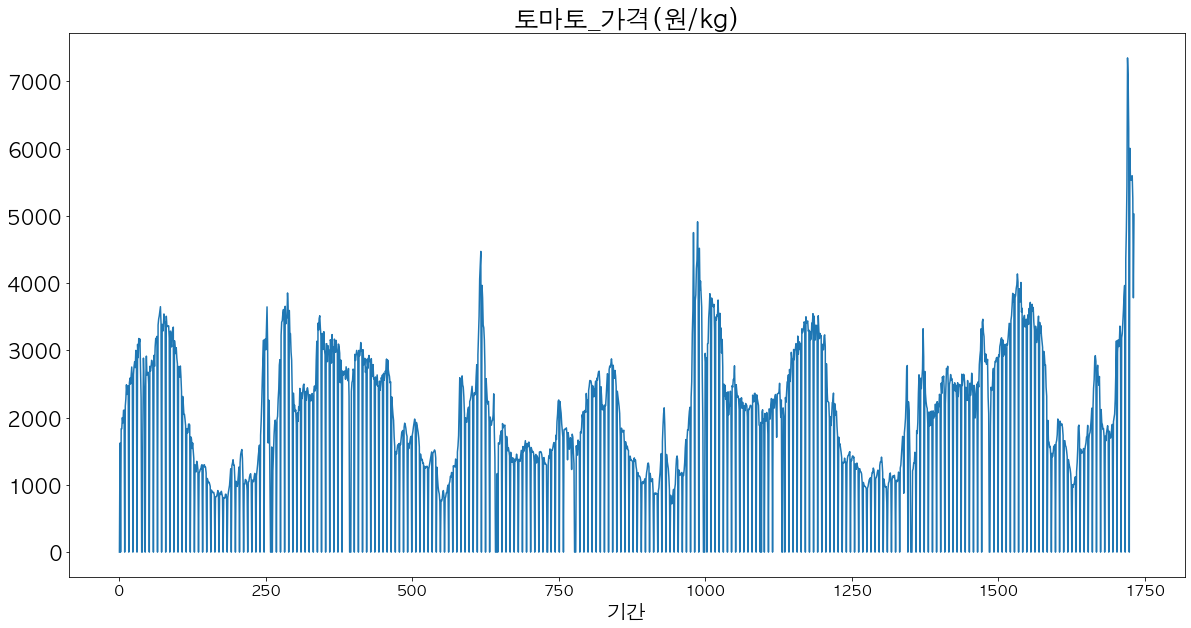

In [80]:
plt.title('토마토_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
train['토마토_가격(원/kg)'].plot(figsize=(20,10))

<AxesSubplot:title={'center':'캠벨얼리_가격(원/kg)'}, xlabel='기간'>

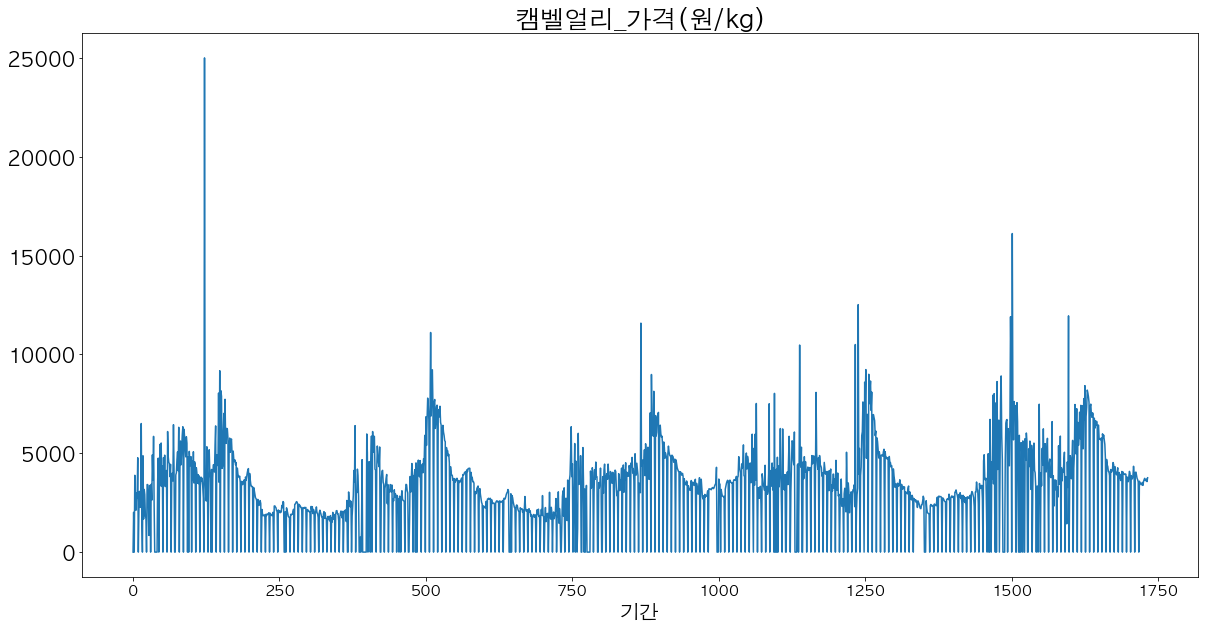

In [81]:
plt.title('캠벨얼리_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
train['캠벨얼리_가격(원/kg)'].plot(figsize=(20,10))

<AxesSubplot:title={'center':'샤인마스캇_가격(원/kg)'}, xlabel='기간'>

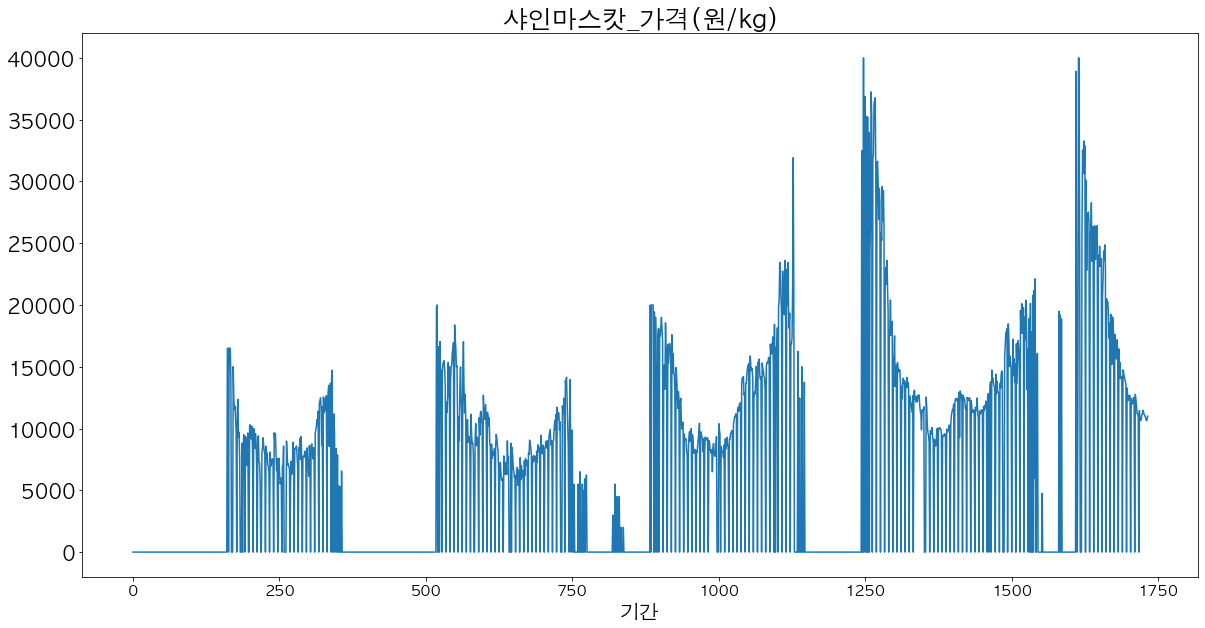

In [82]:
plt.title('샤인마스캇_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
train['샤인마스캇_가격(원/kg)'].plot(figsize=(20,10))

## 농산물 가격 분포
특이값이 많이 포함되어 있음 (이상치가 아니라 우리가 예측해야 하는 값)

<AxesSubplot:>

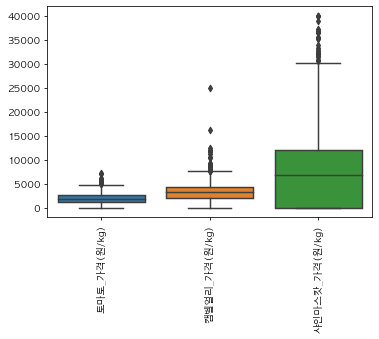

In [15]:
fig = plt.figure(dpi=70)
plt.xticks(rotation = 90)
sns.boxplot(data = train[feature[1::2]])

## 특이값 발생 원인

토마토 가격 0이 아닐경우만 시각화
> 2020년 장마+태풍으로 토마토 출하량 급감 -> 가격 폭등 <br>
e.g.) 추석 연휴 기간내내 롯데리아, 맥도날드, 버거킹과 같은 유명 패스트푸드 전문점은 일제히 "햄버거 안에 토마토가 없어 죄송하다"고 공지,  <br>
일부 햄버거의 경우 토마토를 빼고 팜

[재배방법 및 시기](https://www.nongsaro.go.kr/portal/ps/psb/psbl/workScheduleDtl.ps?menuId=PS00087&cntntsNo=30646&sKidofcomdtySeCode=VC)
<br>
**수확시기: 3월 ~ 6월**

<AxesSubplot:>

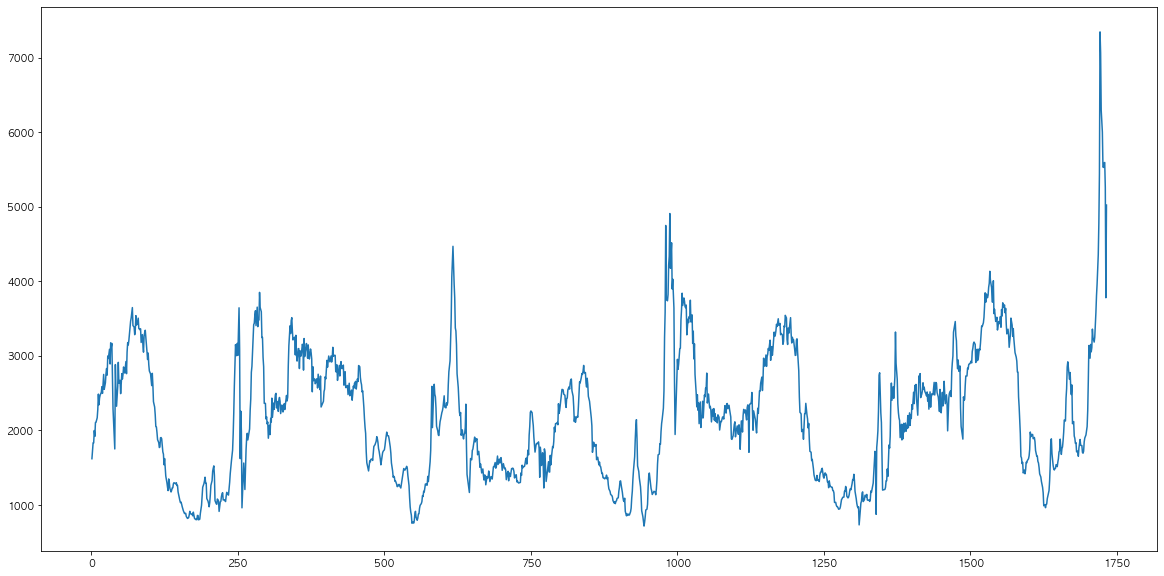

In [16]:
train[train['토마토_가격(원/kg)'] > 1]['토마토_가격(원/kg)'].plot(figsize=(20,10))


캠벨얼리 가격 0이 아닐경우만 시각화 
> FTA로 국내 포도 농가 급감 (FTA로 수입 포도 물량이 급증하면서 포도 가격이 하락한 게 주원인, 캠벨얼리가 지난 2011년 4천716원에서 지난해 3천590원) -> 거래량 줄어들면서 가격 상승

[재배방법 및 시기](https://www.ganghwa.go.kr/open_content/agriculture/info/technic/grape.jsp)<br>
**수확시기 8월 하(캠벨얼리) 9월 중(거봉)**

<AxesSubplot:>

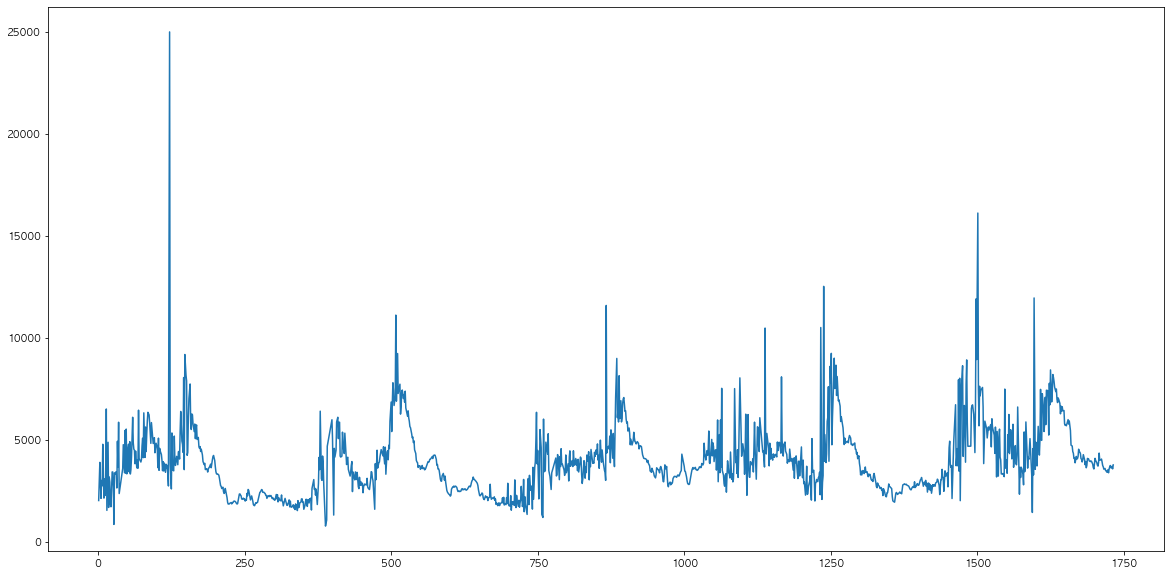

In [17]:
train[train['캠벨얼리_가격(원/kg)'] > 1]['캠벨얼리_가격(원/kg)'].plot(figsize=(20,10))

**샤인마스캇** 가격 0이 아닐경우만 시각화

> 가격 폭등 2017년부터 매년 50% 이상 매출이 늘고 있다. 농경연은 이달 출하하는 샤인머스캣의 가격이 2㎏에 1만7000 ~ 1만9000원 수준으로 전년 가격 대비 10~20% 가량 내려갈 것으로 전망

[재배방법 및 시기](https://lib.rda.go.kr/search/mediaView.do?sysdiv=CAT&ctrl=000000631955)<br>
**수확시기: 8월말 ~ 10월 중순**

<AxesSubplot:>

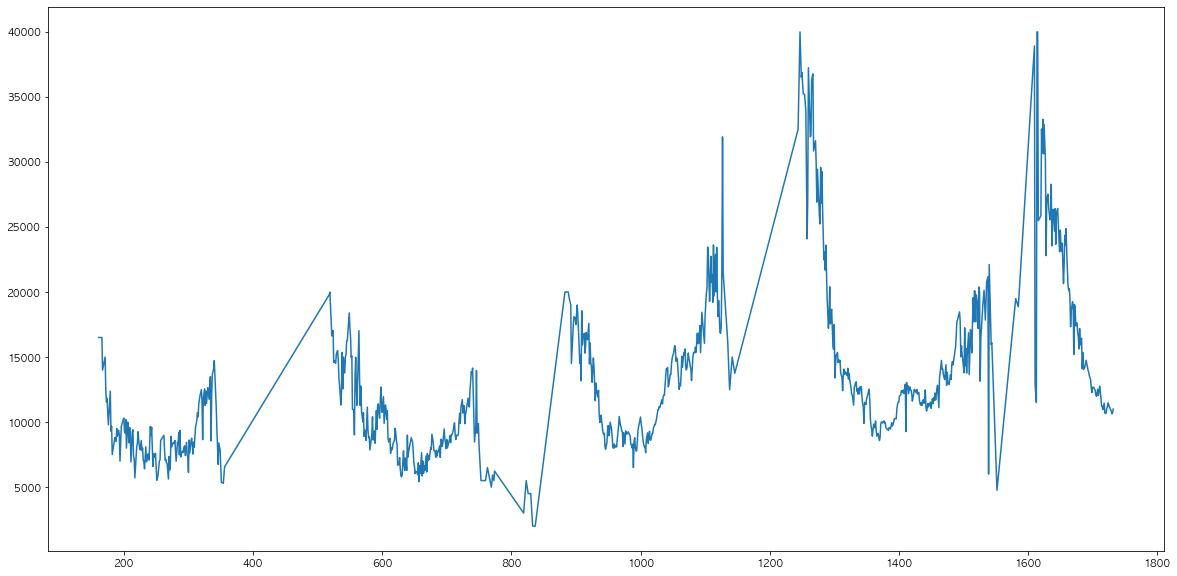

In [18]:
train[train['샤인마스캇_가격(원/kg)'] > 1]['샤인마스캇_가격(원/kg)'].plot(figsize=(20,10))

## 1. 토마토 EDA (tomato)

### 1-1. 토마토 거래량이 가격에 영향을 끼치는가?

> 생산량과 가격은 상관관계 거의 없음

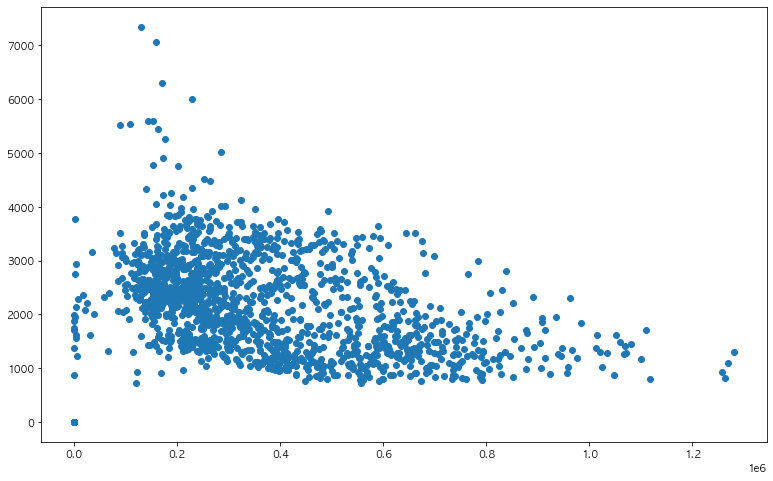

In [23]:
x = tomato['토마토_거래량(kg)']
y = tomato['토마토_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

In [37]:
tomato.iloc[:,:4].corr()

,토마토_거래량(kg),토마토_가격(원/kg)
토마토_거래량(kg),1.00000,0.12301
토마토_가격(원/kg),0.12301,1.00000


### 1-2. 토마토의 전년도 생산량은 당해 연도 4월 가격에 영향을 끼치는가?

In [82]:
output = tomato[tomato['년'] == 2020]
output = output.iloc[:,3].reset_index(drop=True)
output

0      1995.0
1      2208.0
2      2437.0
3      2500.0
4         0.0
        ...  
267    5587.0
268    5596.0
269    5262.0
270    3781.0
271    5024.0
Name: 토마토_가격(원/kg), Length: 272, dtype: float64

In [79]:
price_yang =  tomato[tomato['월']== 5].reset_index(drop=True) # 5월만 추출(수확시기)
price_yang = price_yang[price_yang['년'] == 2019].reset_index(drop=True)
price_yang = price_yang.iloc[:,2]

In [80]:
output = pd.DataFrame(output)
price_yang = pd.DataFrame(price_yang)

data = pd.concat([output, price_yang], axis = 1)

In [81]:
corr = data.corr(method='pearson')
corr

,토마토_가격(원/kg),토마토_거래량(kg)
토마토_가격(원/kg),1.000000,0.655376
토마토_거래량(kg),0.655376,1.000000


### 1-3.  토마토의 생산량은 요일의 영향을 끼치는가?


### 1-4. 토마토의 가격은 날씨데이터에 영향을 끼치는가?

https://docs.google.com/presentation/d/1icum8x1jnlipEk4qn_n7-pvYj5bPvF7_/edit#slide=id.p4

### 1-5. 토마토의 가격은 소비자물가지수에 영향을 끼치는가?

### 1-6. 토마토의 가격은  유가(보통휘발유)에 영향을 끼치는가?

## 2. 캠벨얼리 EDA (grape)
### 2-1. 캠벨얼리 거래량이 가격에 영향을 끼치는가?
> 생산량과 가격은 상관관계 거의 없음

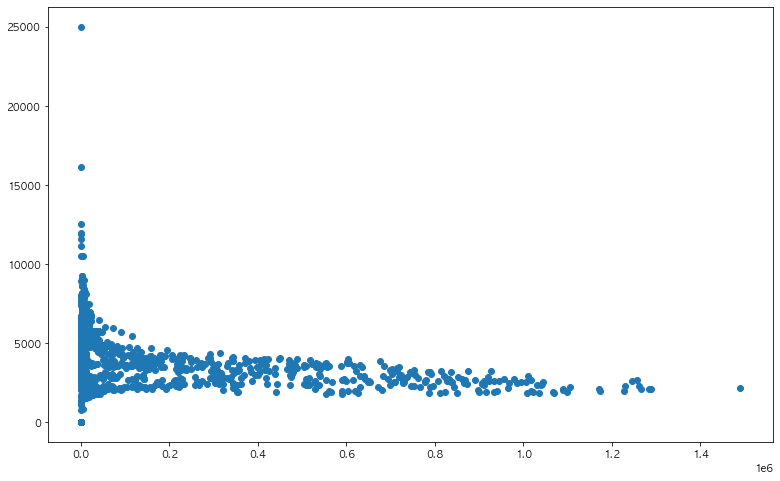

In [73]:
x = grape['캠벨얼리_거래량(kg)']
y = grape['캠벨얼리_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

### 2-2. 캠벨얼리의 전년도 생산량은 당해 연도 4월 가격에 영향을 끼치는가?

In [56]:
output = [tomato['년'] == 2020]
output = output.iloc[:,2].reset_index(drop=True)
output

0         390.0
1       24946.0
2      290136.1
3      131631.4
4           0.0
         ...   
267    142487.0
268    152575.5
269    176807.0
270       910.0
271    285116.5
Name: 토마토_거래량(kg), Length: 272, dtype: float64

In [57]:
price_yang =  tomato[tomato['월']==5].reset_index(drop=True) # 5월만 추출(수확시기)
price_yang = price_yang[price_yang['년'] < 2020].reset_index(drop=True)
price_yang = price_yang.iloc[:,3]

In [58]:
output = pd.DataFrame(output)
price_yang = pd.DataFrame(price_yang)

data = pd.concat([output, price_yang], axis = 1)

In [60]:
corr = data.corr(method='pearson')
corr

,토마토_거래량(kg),토마토_가격(원/kg)
토마토_거래량(kg),1.000000,0.149154
토마토_가격(원/kg),0.149154,1.000000


### 2-3.  캠벨얼리의 생산량은 요일의 영향을 끼치는가?

### 2-4. 캠벨얼리의 가격은 날씨데이터에 영향을 끼치는가?

### 2-5. 캠벨얼리의 가격은 소비자물가지수에 영향을 끼치는가?

### 2-6. 캠벨얼리의 가격은 유가에 영향을 끼치는가?

## 3. 샤인머스캇 EDA (shinemuscat)
### 3-1. 샤인머스캇 거래량이 가격에 영향을 끼치는가?
> 생산량과 가격은 상관관계 거의 없음

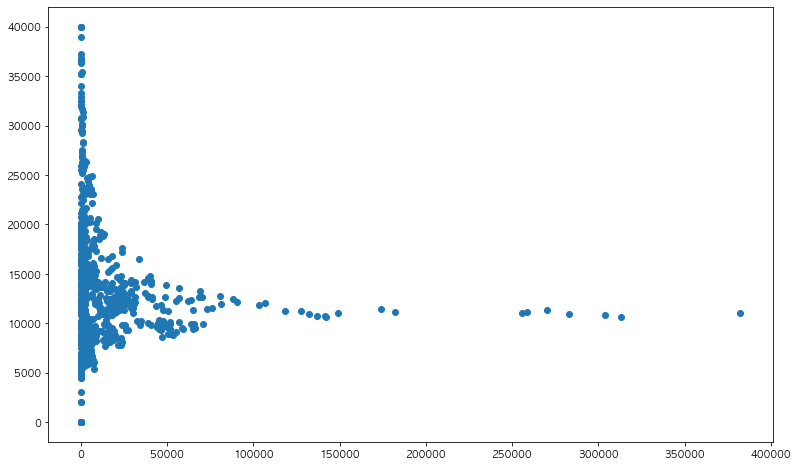

In [76]:
x = shinemuscat['샤인마스캇_거래량(kg)']
y = shinemuscat['샤인마스캇_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

In [38]:
corr = shinemuscat.iloc[:,:4].corr(method='pearson')
corr

,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
샤인마스캇_거래량(kg),1.000000,0.158609
샤인마스캇_가격(원/kg),0.158609,1.000000


### 3-2. 샤인머스캇의 전년도 생산량은 당해 연도 4월 가격에 영향을 끼치는가?
> 전년산 생산량과 가격의 상관관계 있음

In [83]:
output = shinemuscat[shinemuscat['년'] == 2020]
output = output.iloc[:,3].reset_index(drop=True)
output

0          0.0
1      11112.0
2      13399.0
3      13786.0
4          0.0
        ...   
267    10940.0
268    10844.0
269    10636.0
270    10699.0
271    10998.0
Name: 샤인마스캇_가격(원/kg), Length: 272, dtype: float64

In [79]:
price_yang =  shinemuscat[shinemuscat['월']== 4].reset_index(drop=True) # 5월만 추출(수확시기)
price_yang = price_yang[price_yang['년'] == 2019].reset_index(drop=True)
price_yang = price_yang.iloc[:,2]

In [80]:
output = pd.DataFrame(output)
price_yang = pd.DataFrame(price_yang)

data = pd.concat([output, price_yang], axis = 1)

In [81]:
corr = data.corr(method='pearson')
corr

,토마토_가격(원/kg),토마토_거래량(kg)
토마토_가격(원/kg),1.000000,0.655376
토마토_거래량(kg),0.655376,1.000000


### 3-3.  샤인머스캇의 생산량은 요일의 영향을 끼치는가?

### 3-4. 샤인머스캇의 가격은 날씨데이터에 영향을 끼치는가?

### 3-5. 샤인머스캇의 가격은 소비자물가지수에 영향을 끼치는가?

### 3-6. 샤인머스캇의 가격은 유가에 영향을 끼치는가?

## 상관관계 파악

### 토마토 상관관계 파악

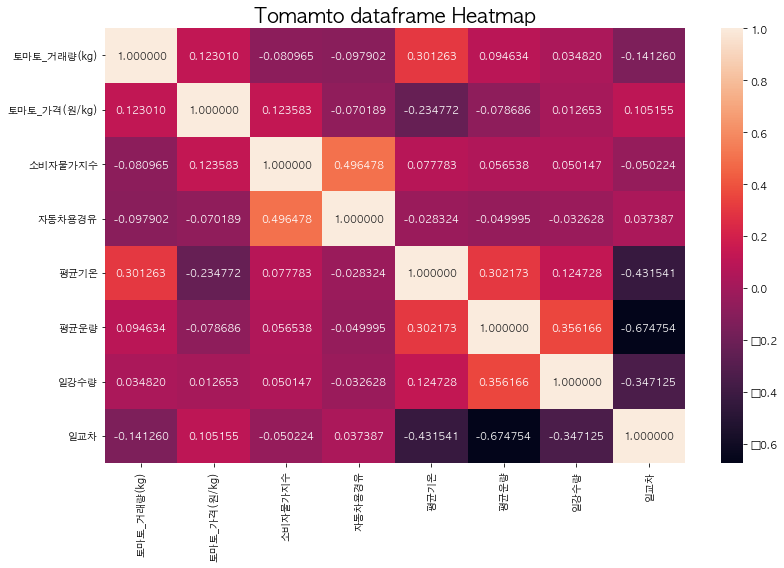

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

tomato_corr = tomato.corr()
ax = sns.heatmap(tomato_corr, annot=True, fmt='f')
plt.title('Tomamto dataframe Heatmap', fontsize=20)
plt.show()

### 캠벨얼리 상관관계 파악

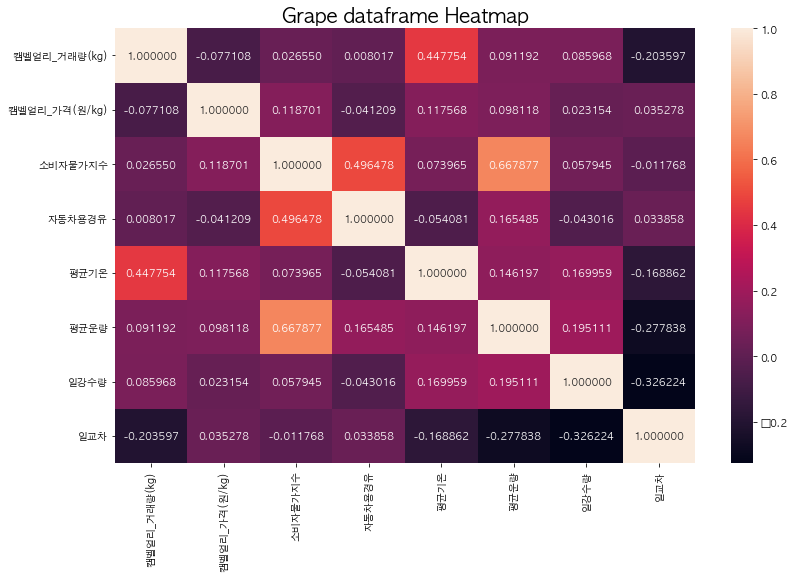

In [46]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

grape_corr = grape.corr()
ax = sns.heatmap(grape_corr, annot=True, fmt='f')
plt.title('Grape dataframe Heatmap', fontsize=20)
plt.show()

### 샤인머스캇 상관관계 파악

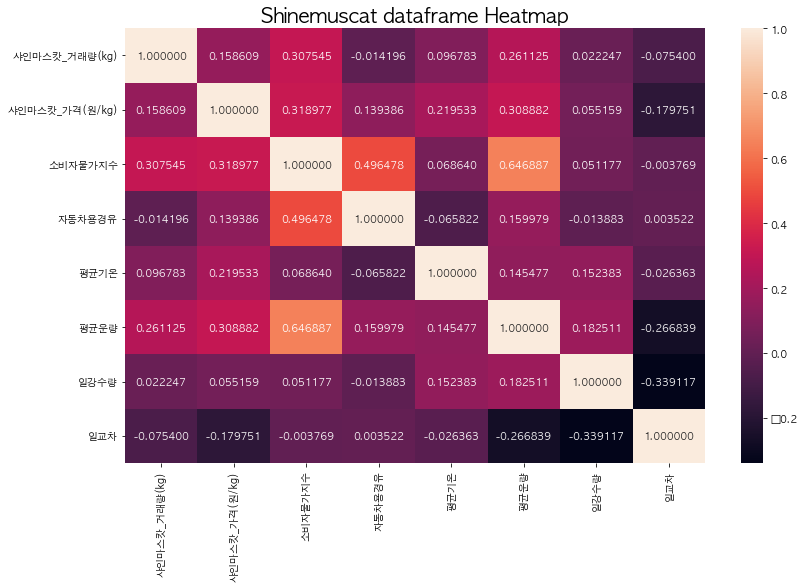

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

shinemuscat_corr = shinemuscat.corr()
ax = sns.heatmap(shinemuscat_corr, annot=True, fmt='f')
plt.title('Shinemuscat dataframe Heatmap', fontsize=20)
plt.show()

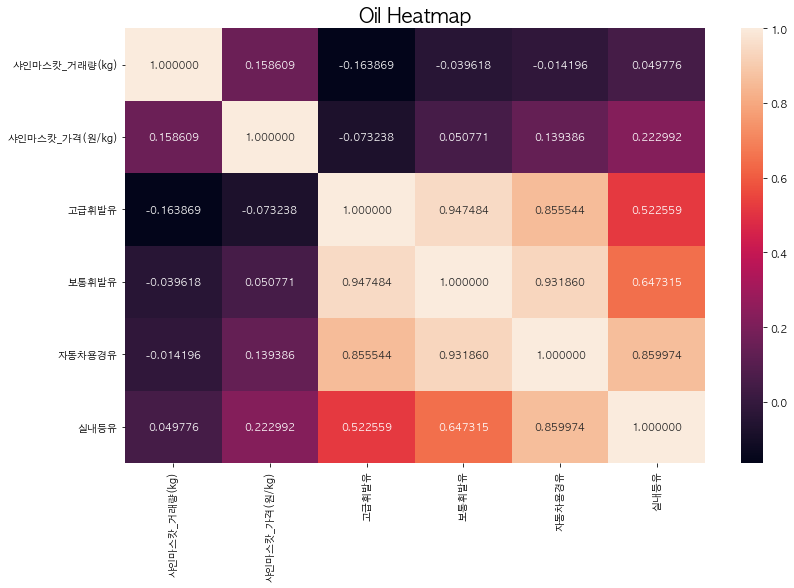

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

oil = pd.concat([shinemuscat.iloc[:,2:4], shinemuscat.iloc[:,5:9]], axis = 1)
oil_corr = oil.corr()
ax = sns.heatmap(oil_corr, annot=True, fmt='f')
plt.title('Oil Heatmap', fontsize=20)
plt.show()

# Data Preproceesing